# **Modelling and Evaluation Notebook**

## Objectives

Answer business requirement 2 and 3:
- The client is interested to tell whether a given plant is Healthy or Powdery
- Provide recommendations for treating plants infected with powdery mildew

## Inputs

- inputs/datasets/cherry-leaves/train
- inputs/datasets/cherry-leaves/validation
- inputs/datasets/cherry-leaves/test
- image shape embeddings

## Outputs
- Images distribution plot in train, validation, and test set
- Image augmentation
- Class indices to change prediction inference in labels
- Machine learning model creation and training
- Save model
- Learning curve plot for model performance
- Model evaluation on pickle file
- Prediction on the random image file

### Additional Comments

Version 1 will be created and try different ways to fit the model to chose which has more accuracy


---
## **Prepare Data Directories**

#### Import libraries


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

#### Change working directory

- Change the working directory from its current folder to its parent folder
- Access the current directory with os.getcwd()

In [3]:
import os
current_dir = os.getcwd()
current_dir


'/workspace/mildew-detector/jupyter_notebooks'

Make the parent of the current directory the new current directory

- os.path.dirname() gets the parent directory
- os.chir() defines the new current directory

In [4]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [5]:
work_dir = os.getcwd()
work_dir

'/workspace/mildew-detector'

---

### Set input directories

Set train, validation and test paths

In [6]:
my_data_dir = 'inputs/cherry_dataset/cherry-leaves'
train_path = os.path.join(my_data_dir, 'train')
val_path = os.path.join(my_data_dir, 'validation')
test_path = os.path.join(my_data_dir, 'test')

# Verify that the directories exist
for path in [train_path, val_path, test_path]:
    if not os.path.isdir(path):
        raise ValueError(f"Directory does not exist: {path}")


### Set output directory

In [7]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version already exists, please create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version already exists, please create a new version.


### Set labels

In [8]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)

Project Labels: ['healthy', 'powdery_mildew']


### Set image shape

Import the image shape from the output folder using the library joblib


In [9]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(50, 50, 3)

---

### **Number of images in train, test and validation data**

- Get the number of images in the train, validation and test datasets, and plot them
- To help visualize, we add the numbers into a dataframe and create a barplot

 train - healthy: 1472 images
 train - powdery_mildew: 1472 images
 validation - healthy: 210 images
 validation - powdery_mildew: 210 images
 test - healthy: 422 images
 test - powdery_mildew: 422 images




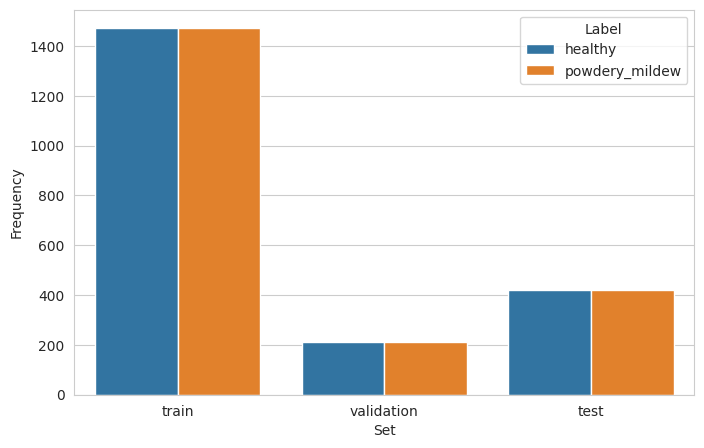

In [10]:
df_freq = pd.DataFrame([])
# Create a dataframe and append each folder to it, and for each of them, every
# label and its frequency.
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir+'/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f" {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
# Create the figure to plot the dataframe
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Image data augmentation

- Generate different images in the train set to use them during the training. We import the library ImageDataGenerator to do it. The images will be created in an artificial and temporarilly way, in RAM memory

- The ImageDataGenerator takes the images from the set and performs different operations like rotations, shifts, zooms and flips to effectively create "new" images that are added to the set. This way, the new images retain the original features, in this case the leaf shape, color and markings on the leaves, but have small variations in them.


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


 Initialize ImagaDataGenerator


In [12]:

augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

Augment training image dataset


In [13]:
# Set to generate 20 images for each image in the dataset, and save them as train_set variable
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

# Print out some information
print("Class indices:", train_set.class_indices)
print("Number of classes:", len(train_set.class_indices))
print("Number of samples:", train_set.samples)

Found 2944 images belonging to 2 classes.
Class indices: {'healthy': 0, 'powdery_mildew': 1}
Number of classes: 2
Number of samples: 2944


Augment validation image dataset

In [14]:
# Augmenting the validation images only by standardizing image pixels between 0 to 255
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Augment test image dataset


In [15]:
# Augmenting the test images only by standardizing image pixels between 0 to 255
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmented training images

- Plot some samples from the augmented images to check that we still see the relevant features

(20, 50, 50, 3)


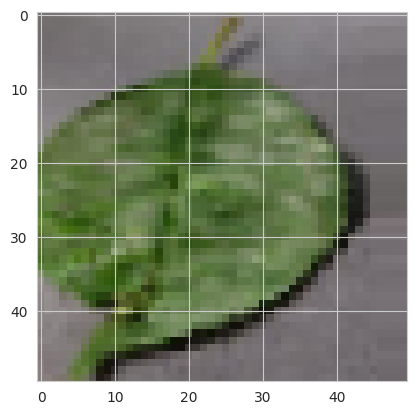

(20, 50, 50, 3)


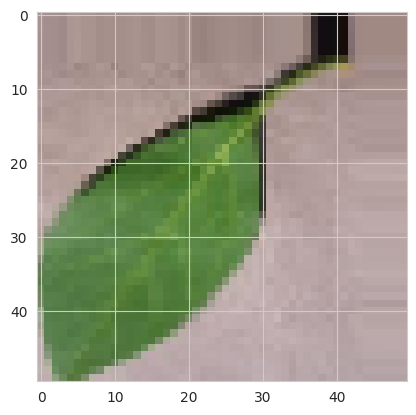

(20, 50, 50, 3)


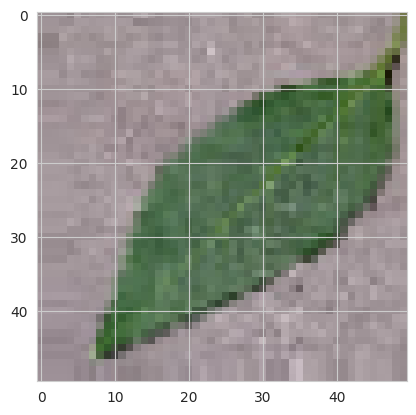

In [16]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Plot augmented validation and test images


(20, 50, 50, 3)


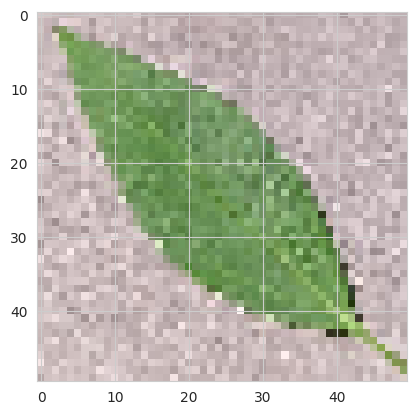

(20, 50, 50, 3)


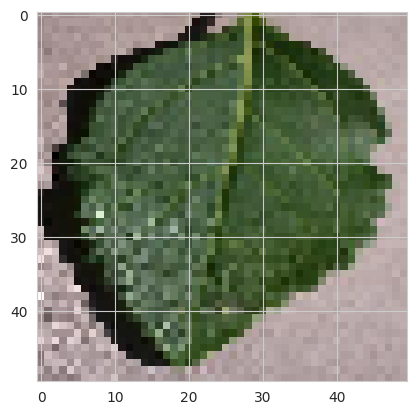

(20, 50, 50, 3)


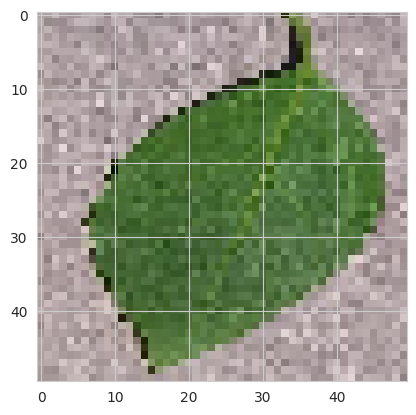

In [17]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(20, 50, 50, 3)


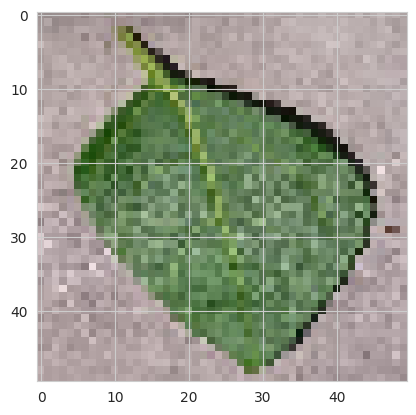

(20, 50, 50, 3)


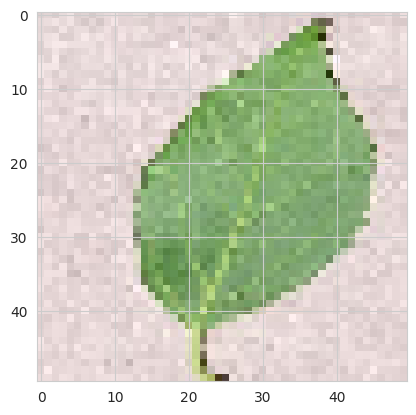

(20, 50, 50, 3)


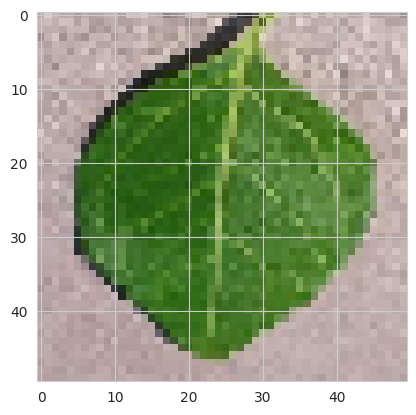

In [19]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()